# Gesture Recognition - Case Study

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

### Objectives :

*We need to accomplish the following in this case study :*

 > **1. Generator :**  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

 > **2. Model:** Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

 > **3. Write up:** This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

### Please Note :

1. *This notebook contains only **the top 3 models (based on performance)** of each type* (Conv3D and CNN+RNN) out of the total of 15 models tried.


2. **Google Colab** *was used to build and train the models.*

## Contents
---------------------------------------------------------------------

> **1. Initial Setup**

> **2. Define Generator**

> **3. Model Building :**

         i) Conv3D
    
         ii) CNN + RNN
         
           - using VGGNet
           - using MobileNet
         
    

> **4. Model Fine Tuning and Experimentation**

> **5. Final Model and insights**

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%ls


Mounted at /content/drive
drive/  sample_data/


In [2]:
%cd drive/MyDrive/GR_Data

/content/drive/MyDrive/GR_Data


In [3]:
!unzip /content/drive/MyDrive/GR_Data/Project_data.zip -d .

Streaming output truncated to the last 5000 lines.
 extracting: ./Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: ./Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: ./Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: ./Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: ./Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: ./Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: ./Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: ./Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: ./Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracti

**Please Note :**
    
    We are downgrading scipy from 1.4.1 to 1.1.0 in order to be able to use imread & imresize which are not supported in the latest versions of Scipy

In [4]:
pip install scipy==1.1.0

     |████████████████████████████████| 31.2 MB 173 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.4 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
jax 0.2.25 requires scipy>=1.2.1, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## 1. Initial Setup

### 1.1 Import required libraries

In [5]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
import abc
from sys import getsizeof
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [6]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)

In [7]:
## import matplotlib libraries

import cv2
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow
%matplotlib inline


In [8]:
## import keras libraries

from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.layers import TimeDistributed
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

### 1.2 Load Data

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [9]:
# we first initialise the folder where project data resides

project_folder = 'Project_data'

#we use np.random to shuffle data in order to ensure the same gesture images do not get accumulated together
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())

#batch size used
batch_size = 16


## 2. Generator

In the generator, we preprocess the images as we have images of 2 different dimensions. 
We also create a batch of video frames. 

         We also experimented with `img_idx`, `y`,`z` and normalization to ensure a high accuracy.

**Here, we will define our Generator which contains :**


    
 > 1. min_max_scaler() : To scale and normalise images channel wise in order to maintain uniform scale per channel (0 to 1)
 
 > 2. load_image() : To resize and crop images and remove noise (using imread and .resize functions)
 
 > 3. generator()
 

### Note :
 > Since all images despite being RGB, **vary in contrast and brightness**, simply dividing by 255 may not be the right way to normalise. 
 Hence we go ahead with **min-max normalisation** :
         
         img - np.min(img) /np.max(img)-np.min(img)
 



In [10]:
import imageio
from PIL import Image

#image width
y = 84
#image height
z = 84

#15 random indexes selected out of 30 in total
img_idx = [2,4,5,7,9,11,13,15,17,19,20,23,25,28,29]

#number of frames
x = len(img_idx)

#function to scale and normalise images channel wise (RGB)
def min_max_scaler(img):
    for ch in (0, 1, 2):
        img_ch = img[:, :, ch]
        min_val = np.amin(img_ch)
        max_val = np.amax(img_ch)
        
        #normalising images using min max scalar
        img[:, :, ch] = (img_ch - min_val) / (max_val - min_val)


#function to crop and resize images to specified height & width
def load_image(img_url):
    image = imageio.imread(img_url)
    image = np.array(Image.fromarray(image).resize(size=(y, z)), dtype = np.float64)
    min_max_scaler(image)
    return image


#generator function
def generator(source_path, folder_list, batch_size):
    while True:

        #to shuffle data in order to avoid similar data getting accumulated
        t = np.random.permutation(folder_list)
        total_data = len(t)

        # num of batches = int(len(t)/batch_size)
        num_batches = int(total_data/batch_size)

        #iterate over batches
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,x,y,z,3))
            
            
            # dimensions of batch_labels = np.zeros((batch_size,5))
            batch_labels = np.zeros((batch_size,5))
            
            #iterate over images
            for folder in range(batch_size):
                images = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    batch_data[folder, idx, :, :] = load_image(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+images[item])
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

       
        #to fetch the batches remaining after full batches
        last_batch = num_batches * batch_size
        rem_batch_size = int(total_data - last_batch)
        if rem_batch_size:
            batch_data = np.zeros((rem_batch_size,x,y,z,3))
            batch_labels = np.zeros((rem_batch_size,5))
            for folder in range(rem_batch_size):
                images = os.listdir(source_path+'/'+ t[folder + last_batch].split(';')[0])
                for idx,item in enumerate(img_idx):
                    batch_data[folder, idx, :, :] = load_image(source_path+'/'+ t[folder + last_batch].strip().split(';')[0]+'/'+images[item])

                batch_labels[folder, int(t[folder + last_batch].strip().split(';')[2])] = 1
            
            #to return the generator and iterate through it to extract images
            yield batch_data, batch_labels


**ReduceLROnPlateau :** A callback to reduce the learning rate when a metric has stopped improving. This callback monitors a quantity and if no improvement is seen, the learning rate is reduced by factor value ( new_lr = lr * factor ).
    

**warpAffineAffine :** It's a linear mapping method that preserves points, straight lines, and planes. Sets of parallel lines remain parallel after an affine transformation. The affine transformation technique is typically used to correct for geometric distortions or deformations that occur with non-ideal camera angles.    

### Test an image loaded

In [11]:
#Test an image 


test_img = './Project_data/val/WIN_20180926_17_32_40_Pro_Stop_new/WIN_20180926_17_32_40_Pro_00049.png'

In [12]:
img = load_image(test_img)

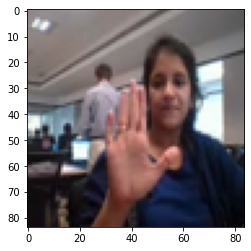

In [13]:
imshow(img)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [14]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
## Plot Results

In [47]:
# function to plot the accuracy and loss of training and validation sets

def plot(result):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(result.history['loss'], color= 'red')   
    axes[0].plot(result.history['val_loss'], color='green')
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(result.history['categorical_accuracy'], color= 'red')   
    axes[1].plot(result.history['val_categorical_accuracy'], color='green')
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.show()

# 3. Model Building

Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.


    1. CNN Conv3D
    
    2. CNN + RNN

## Model - 1 - CNN Conv3D



  
  **Optimiser used** - *SGD*

  **learning rate** - 0.002
  
  **Activation used** - *ELU for Fully connected and Softmax for output layer*

  **number of epochs** - 20

  **batch-size** = 16

  **image resolution used** = 84x84
  
  **Frames to sample** = 15 (out of total 30)
  
  

###  Why ELU ?

 > **ELU - Exponential Linear Unit** a function that tends to converge cost to zero faster and produce more accurate results. It has an extra alpha constant which should be positive number. ELU is very similiar to RELU except for negative inputs

 - Doesn’t have the dying ReLU problem.
 - The function tends to converge cost to zero faster and produces more  accurate results.
 - More of a merger between good features of ReLU & Leaky ReLU.

In [ ]:
model = Sequential()
classes = 5

  
#1st Convolution Block : consists of convolution layers followed by Pooling layer and elu activation aplied
model.add(Conv3D(16, (3, 3, 3), padding = 'same', input_shape=(x,y,z,3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size= (2,2,2)))

# 2nd  Convolution Block 
model.add(Conv3D(32, (3, 3, 3), padding = 'same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size= (2,2,2), strides= (2,2,2)))


# 3rd  Convolution Block 
model.add(Conv3D(64, (3, 3, 3), padding = 'same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size= (2,2,2)))


# Flattening layer
model.add(Flatten())
model.add(Dense(64, activation ='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


#Fully Connected dense layers
model.add(Dense(64, activation ='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
# Softmax Layer (Output)
model.add(Dense(classes, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

**Optimizer used : SGD**

In [ ]:
optimiser = tf.keras.optimizers.SGD(lr = 0.002, decay=1e-6, momentum=0.7, nesterov= True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 84, 84, 16)    1312      
                                                                 
 activation (Activation)     (None, 15, 84, 84, 16)    0         
                                                                 
 batch_normalization (BatchN  (None, 15, 84, 84, 16)   64        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 42, 42, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 42, 42, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 7, 42, 42, 32)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model_name = 'model_conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print("Number of Parameters : ", model.count_params())
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = 'val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]


Number of Parameters :  485637


In [ ]:
batch_size = 16

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
Conv_3D  = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 1.6160 - categorical_accuracy: 0.4178
Epoch 00001: val_loss improved from inf to 1.48639, saving model to model_conv3D_2022-01-0904_19_40.590747/model-00001-1.61597-0.41780-1.48639-0.26000.h5
42/42 [==============================] - 318s 8s/step - loss: 1.6160 - categorical_accuracy: 0.4178 - val_loss: 1.4864 - val_categorical_accuracy: 0.2600 - lr: 0.0020
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 0.9933 - categorical_accuracy: 0.5973
Epoch 00002: val_loss did not improve from 1.48639
42/42 [==============================] - 316s 8s/step - loss: 0.9933 - categorical_accuracy: 0.5973 - val_loss: 2.4176 - val_categorical_accuracy: 0.1400 - lr: 0.0020
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 0.7058 - categorical_accuracy: 0.7179
Epoch 00003: val_loss did not improve from 1.48639

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
42/42 [====

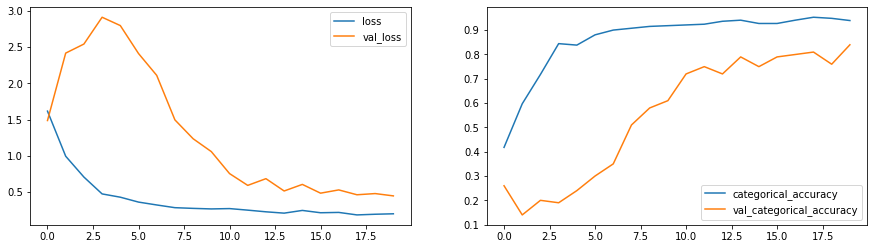

In [ ]:
import matplotlib.pyplot as plt
plot(Conv_3D)

### That indeed is the best accuracy so far on train and validation dataset for Conv3D model. 

    Finally after trying multiple models, we got the best results so far for Conv3D model
    
    In 20 epochs, we managed to achieved a fairly high accuracy with minimal parameters using Conv3D model

 > **Number of Parameters :  485,637**

 > **Training Accuracy : 93%**

 > **Validation Accuracy : 84%**
    
*However there is a **slight overfitting** indication.*

    We will now move to the second approach - using CNNs and RNNs . . .

# Model - 2 CNN+RNN (GRU)

#### We tried multiple models by training our own CNN followed by RNN (GRU)

However, the performance improved *drastically after using **Transfer Learning** made the process a lot faster* 

    The top two models of this approach have been showcased in this notebook (below)
    
 > i) *CNN+RNN (GRU)* - **using VGG16 (imagenet)**
 
 > ii) *CNN+RNN (GRU)* - **using MobileNet (imagenet)**

### Transfer Learning in action . . .

 There are two ways we could have used Transfer Learning :

   1. Freeze the initial layers - use same weights and biases that the network has learnt from some other task

   2. Fine-tune the model - retrain all or few layers starting from weights and biases that net has already learnt.

 > **Point to note here** - We must use a **low Learning Rate** here as we don't expect the weights to change drastically. We want the layers to retain the useful learnt knowledge (of generic patterns) and only want to tune a little in order to accomodate for new classification task here
 

*We tried both the ways and discovered that retraining some of the weights of the pretrained models(with a low learning rate) actually improves the model performance*
 



### 2. i) CNN+RNN (GRU) - using VGG16 (imagenet)

  
  
  **Base Model used** : *VGG16*
  
  **Weights used** : *imagenet*
  
  **Optimiser used** - *SGD*

  **learning rate** - 0.001
  
  **Activation used** - *RELU for Fully connected and Softmax for output layer*

  **number of epochs** - 10

  **batch-size** = 16

  **image resolution used** = 84x84
  
  **Frames to sample** = 15
  
  
     We have made use of Dropouts after GRU layers


We used **“include_top” set to False,** to allow a new output layer to be added and trained and ensure that the fully-connected output layers of the model (used to make final predictions) are not loaded

In [ ]:
#define base model
base_model =  VGG16 (include_top = False, weights = 'imagenet', input_shape=(y,z,3))
features = Dense (64, activation='relu')(Flatten()(base_model.output))

#define convolution model using base model
conv_model = Model(inputs= base_model.input, outputs=features)

sec_model = Sequential()
sec_model.add(TimeDistributed(conv_model, input_shape=(x, y, z, 3)))
sec_model.add(GRU(32, return_sequences=True))
sec_model.add(GRU(16))
sec_model.add(Dropout(0.5))
sec_model.add(Dense(64, activation='relu'))
sec_model.add(Dense(5, activation='softmax'))

#define optimizer
opti = tf.keras.optimizers.SGD(lr=0.0015, decay=1e-6, momentum=0.7, nesterov=True)
sec_model.compile(optimizer=opti, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(sec_model.summary())
     

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 64)           14845824  
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 15, 32)            9408      
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                1088      
                                                                 
 dense_5 (Dense)             (None, 5)                 

In [ ]:
batch_size = 16

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


model_name ='model_rnn_vggnet' + '_' + str(curr_dt_time).replace(':', '_') + '/'
print("Number of Parameters : ", sec_model.count_params())
if not os.path.exists(model_name):
    os.mkdir(model_name)
        

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = 'val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Number of Parameters :  14859045


In [ ]:
num_epochs = 10
print ('# epochs =', num_epochs)

# epochs = 10


In [ ]:
CNNRNN_VGG_GRU =  sec_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Epoch 1/10
42/42 [==============================] - ETA: 0s - loss: 1.6041 - categorical_accuracy: 0.2519  
Epoch 00001: val_loss improved from inf to 1.55845, saving model to model_rnn_vggnet_2022-01-09 04_19_40.590747/model-00001-1.60412-0.25189-1.55845-0.28000.h5
42/42 [==============================] - 2803s 67s/step - loss: 1.6041 - categorical_accuracy: 0.2519 - val_loss: 1.5584 - val_categorical_accuracy: 0.2800 - lr: 0.0015
Epoch 2/10
42/42 [==============================] - ETA: 0s - loss: 1.4548 - categorical_accuracy: 0.4087  
Epoch 00002: val_loss improved from 1.55845 to 1.33864, saving model to model_rnn_vggnet_2022-01-09 04_19_40.590747/model-00002-1.45481-0.40875-1.33864-0.54000.h5
42/42 [==============================] - 2785s 66s/step - loss: 1.4548 - categorical_accuracy: 0.4087 - val_loss: 1.3386 - val_categorical_accuracy: 0.5400 - lr: 0.0015
Epoch 3/10
42/42 [==============================] - ETA: 0s - loss: 1.2912 - categorical_accuracy: 0.5370  
Epoch 00003: val

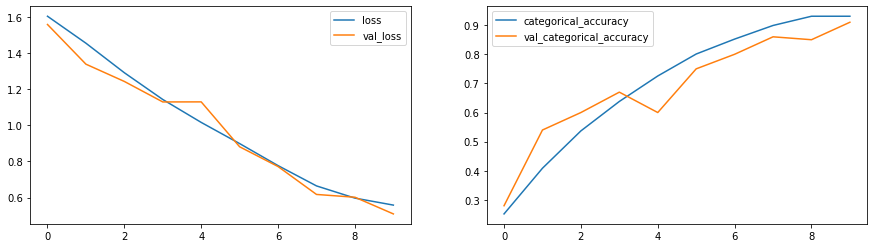

In [ ]:
plot(CNNRNN_VGG_GRU)

### Wonderful Results yet complex and time consuming!

We can see a consistent pattern of increase in accuracy while a decrease in loss for both, training and validation data.

**An accuracy above 90% for both training and validation data in just 10 epochs. This is likely to go up if we train them futher by adding more epochs**

**Final val_loss: 0.5092 which kept decreasing uniformly** through out epochs

> ***Learning Rate of 0.0015*** worked perfectly well for our model!

The only limitation here is an **increase in the number of parameters, which made it a bit time consuming** - 15-20 minutes for each epoch.

 > *VGGNET is quite a complex model and hence this was expected.*

We want to give it another try using Transfer Learning - this time we will make use of **Mobilenet which is much lighter and faster in computation.** We also want to **reduce the number of total trainable parameters** to make our model less complex.

> **Our aim now is to achieve an equally high accuracy (or even higher) with lesser number of paramters and epochs while decreasing the loss further from 0.5**

# Final Model

## 2. ii) CNN+RNN (GRU) - using MobileNet (imagenet)

### Why MobileNet ?

   > **MobileNet is 32 times smaller than VGG16, yet has the same accuracy,** it must be more efficient at capturing specific knowledge than VGG is. It not very computationally intensive, highly efficient and lightweight convolutional neural network.

  **Base Model used** : *Mobilenet*
  
  **Weights used** : *imagenet*
  
  **Optimiser used** - *Adam*

  **learning rate** - ~0.0004
  
  **Activation used** - *RELU for Fully connected and Softmax for output layer*

  **number of epochs** - 10

  **batch-size** = 16

  **image resolution used** = 100x100
  
  **Frames to sample** = reduced to 5



     We are making use of Dropouts after Convolution and FC layers

     We have also added Batch Normalisation to avoid the issue of vannishing or exploding gradients

 We use **“include_top” set to False**, to allow a new output layer to be added and trained and ensure that the fully-connected output layers of the model (used to make final predictions) are not loaded.

In [24]:
#import mobilenet
from keras.applications import mobilenet

#define image resolution variables
x = 5
y = 100
z = 100

#define base model
base_model =  mobilenet.MobileNet(include_top = False, weights = 'imagenet')
ts_model = Sequential()
ts_model.add(TimeDistributed(base_model, input_shape=(x,y,z,3)))

#add RNN layers
ts_model.add(TimeDistributed(BatchNormalization()))
ts_model.add(TimeDistributed(MaxPooling2D((2, 2))))
ts_model.add(TimeDistributed(Flatten()))
ts_model.add(GRU(64))

#add dropouts to avoid overfitting
ts_model.add(Dropout(0.25))
ts_model.add(Dense(64, activation='relu'))
ts_model.add(Dropout(0.25))
ts_model.add(Dense(5, activation='softmax'))

#define optimizer
opti = tf.keras.optimizers.Adam(lr = 0.000038) 
ts_model.compile(optimizer=opti, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(ts_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 16, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 64)               

In [25]:
batch_size = 5

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model_name ='Model_CNN_RNN_GRU_MobiNet' + '_' + str(curr_dt_time).replace(':', '_') + '/'
print("Number of Parameters : ", ts_model.count_params())

if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = 'val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Number of Parameters :  3446725


In [26]:
Model_CNN_RNN_GRU_MobiNet =  ts_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
133/133 [==============================] - ETA: 0s - loss: 1.6198 - categorical_accuracy: 0.2594
Epoch 00001: val_loss improved from inf to 1.45917, saving model to Model_CNN_RNN_GRU_MobiNet_2022-01-11 04_21_11.706411/model-00001-1.61983-0.25943-1.45917-0.40000.h5
133/133 [==============================] - 456s 3s/step - loss: 1.6198 - categorical_accuracy: 0.2594 - val_loss: 1.4592 - val_categorical_accuracy: 0.4000 - lr: 3.8000e-05
Epoch 2/10
133/133 [==============================] - ETA: 0s - loss: 1.4014 - categorical_accuracy: 0.4344
Epoch 00002: val_loss improved from 1.45917 to 1.30798, saving model to Model_CNN_RNN_GRU_MobiNet_2022-01-11 04_21_11.706411/model-00002-1.40142-0.43439-1.30798-0.49000.h5
133/133 [==============================] - 458s 3s/step - loss: 1.4014 - categorical_accuracy: 0.4344 - val_loss: 1.3080 - val_categorical_accuracy: 0.4900 - lr: 3.8000e-05
Epoch 3/10
133/133 [==============================] - ETA: 0s - loss: 1.1785 - categorical_accurac

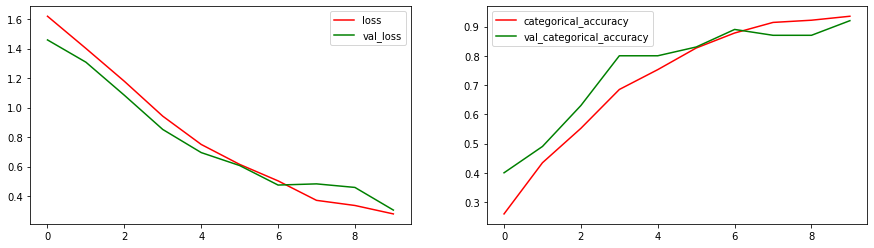

In [60]:
plot(Model_CNN_RNN_GRU_MobiNet)

**note:**

     Initially the training accuracy is slightly lower than validation as we have added DROPOUTS (to avoid overfitting).This improves with apochs and converges at a point after which the training accuracy increases faster and validation accuracy follows it.

### As expected, we get wonderful results in just 10 epochs and Model error decreases with epoch.



*Our aim was to achieve an equally high accuracy (or even higher)-* **Increased from 91 to 92 (accomplished)**

*with lesser number of paramters and epochs -* **parameter reduced by 5 times : 3,446,725 (accomplished)**

*while decreasing the loss further from 0.5 -* **decreased to 0.3 (accomplished)**

    And this is likely to improve further with more epochs.

> **We fix this as our FINAL MODEL!**

## 5. Final Model - Insights


**Training Accuracy = 93%**

**Validation Accuracy = 92%**

**Training Loss = 0.27**

**Validation Loss = 0.30**


  > **Image resolution** changed to = 100x100 (from 84x84)

   > **Frames to sample** = reduced to 5 (from 15) to reduce parameters

   > **batch size = 16** (remains same)

### We tried and saw the following trend for all CNN+RNN models on using LSTM and complex Transfer Learning models like VGGNet :

 > Huge number of parameters
 
> Slight improvment with epochs 

> Exceptionally slow training

***Approx 50 mins-1 hour*** for each epoch :(

### This indeed is not our goal!!!

     Clearly, we would always prefer a lighter, less complex model (with less number of parameters) & faster to train model which results in a fairly high accuracy over a complex, heavy and time consuming model.

> **Our goal here was to :**
    
    Develop a model that is able to train without any errors and has high accuracy with least possible parameters (training time should be less)
        
### Our MobileNet+GRU model helped us achieve  :-

     - higher accuracy (Training Accuracy : 93% and Validation Accuracy : 92%)

     - much faster (7-8 mins per epoch)

     - with less number of parameters (3,446,725) 
     
     - low training and validation loss (Training loss : 0.27 and Validation loss : 0.30)

### WE FINALIZE 'Model_CNN_RNN_GRU_MobiNet' AS OUR PROPOSED MODEL 

> **Please Note :** Final Model weights **(model-00010-0.27850-0.93514-0.30456-0.92000)** are attached within the zip folder

                                           Thank You!